# Evaluate reasoning datasets with `logikon` debuggers

Use this notebook to

* debug a reasoning dataset with `logikon`
* customize `logikon` configuration (e.g., expert_model, debuggers)
* upload debugging results (artifacts and metrics) to huggingface hub

### Set-up

In [9]:
import getpass
import os

GH_ACCESS_TOKEN = getpass.getpass("GH_ACCESS_TOKEN: ")
if GH_ACCESS_TOKEN:
    os.environ["GH_ACCESS_TOKEN"] = GH_ACCESS_TOKEN

OPENAI_API_KEY = getpass.getpass("OPENAI_API_KEY: ")
if OPENAI_API_KEY:
    os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

HUGGINGFACEHUB_API_TOKEN = getpass.getpass("HUGGINGFACEHUB_API_TOKEN: ")
if HUGGINGFACEHUB_API_TOKEN:
    os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

In [2]:
# install logikon module from github repo

# hatch packaging
%pip install hatch

# for using local models with vllm / example 3:
%pip install -U "vllm>=0.1.7" git+https://$GH_ACCESS_TOKEN@github.com/logikon-ai/logikon.git@v0.0.1-dev0
%pip install "tokenizers==0.13.3"
%pip install -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 27.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 58.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 67.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 20.3 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.

In [3]:
%pip list | grep pydantic

pydantic                          1.10.13
Note: you may need to restart the kernel to use updated packages.


### Imports, data models, configs

In [3]:
import dataclasses
import datetime
import json
import os
import pprint
import tempfile
import uuid

import datasets
import huggingface_hub as hf_hub
import logikon
import networkx as nx

print(f"Installed `logikon` module version: {logikon.__version__}")

Installed `logikon` module version: 0.0.1-dev1


In [4]:
@dataclasses.dataclass
class ReferenceDataset:
    """Reference dataset metadata."""
    path: str
    id_field: str = None
    split: str = None
    revision: str = None

@dataclasses.dataclass
class EvalResultRecord:
    """Evaluation result record."""
    id: str
    reference_id: str
    reference_dataset: dict
    lang: str
    created_date: str
    argmap: dict
    scores: dict
    model: str
    metadata: dict

In [5]:
REASONING_DATASET = dict(
    path='logikon/oasst1-delib',
    split='validation',
    revision=None,
    id_field='message_id',
)

EVALRESULTS_DATASET_PATH = 'logikon/delib-evals'

LANG = "en"

DEBUG_CONFIG = dict(
    artifacts=["networkx_graph"],
    metrics=["argmap_size", "argmap_avg_katz_centrality","argmap_attack_ratio"],
    expert_model="tiiuae/falcon-40b-instruct",  # "Open-Orca/OpenOrca-Platypus2-13B",
    llm_framework="VLLM",
    #expert_model="gpt-3.5-turbo-instruct",
    #llm_framework="OpenAI",
)

In [6]:
reference_dataset = ReferenceDataset(**REASONING_DATASET)
config = logikon.DebugConfig(**DEBUG_CONFIG)
evalresults_dataset = dict(
    path=EVALRESULTS_DATASET_PATH,
    filename=f"{config.expert_model.replace('/','_')}_{reference_dataset.split}.jsonl",
    subfolder=os.path.join("data",reference_dataset.path),
)

In [7]:
print(reference_dataset)
print(config)
print(evalresults_dataset)

ReferenceDataset(path='logikon/oasst1-delib', id_field='message_id', split='validation', revision=None)
expert_model='tiiuae/falcon-40b-instruct' expert_model_kwargs={'temperature': 0.7} llm_framework='VLLM' generation_kwargs=None inputs=[] metrics=['argmap_size', 'argmap_avg_katz_centrality', 'argmap_attack_ratio'] artifacts=['networkx_graph'] report_to=[]
{'path': 'logikon/delib-evals', 'filename': 'tiiuae_falcon-40b-instruct_validation.jsonl', 'subfolder': 'data/logikon/oasst1-delib'}


### Load reference dataset

In [10]:
# login to huggingface hub
hf_hub.login(os.environ["HUGGINGFACEHUB_API_TOKEN"])

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/gregorbetz/.cache/huggingface/token
Login successful


In [8]:
# load the reference dataset
ref_ds = datasets.load_dataset(
    reference_dataset.path,
    split=reference_dataset.split,
    revision=reference_dataset.revision,
)
ref_ds

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/90 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6 [00:00<?, ? examples/s]

Dataset({
    features: ['message_id', 'parent_id', 'user_id', 'created_date', 'text', 'role', 'lang', 'review_count', 'review_result', 'deleted', 'rank', 'synthetic', 'model_name', 'detoxify', 'message_tree_id', 'tree_state', 'emojis', 'labels', 'history'],
    num_rows: 6
})

In [9]:
# optional: check ref dataset features
# ref_ds.features

In [10]:
assert reference_dataset.id_field in ref_ds.features, f"Reference dataset must have {reference_dataset.id_field} field."

In [11]:
# download the eval results dataset (if exists)
eval_results = []

if hf_hub.file_exists(
    evalresults_dataset["path"], os.path.join(evalresults_dataset["subfolder"], evalresults_dataset["filename"]),
    repo_type="dataset",
    token=os.environ["HUGGINGFACEHUB_API_TOKEN"],
):
        
    eval_file = hf_hub.hf_hub_download(
        evalresults_dataset["path"],
        filename=evalresults_dataset["filename"],
        subfolder=evalresults_dataset["subfolder"],
        repo_type="dataset"
    )

    with open(eval_file) as f:
        for line in f:
            record = EvalResultRecord(**json.loads(line))
            eval_results.append(record)

    print(f"Loaded {len(eval_results)} eval results.")

else:
    print("No eval results loaded.")
    


No eval results loaded.


In [12]:
# iterate over the reference dataset:
# - compute the metrics for records not in the eval results dataset
# - update the eval results dataset

for enum, example in enumerate(ref_ds):  # ref_ds.select(list(range(60)))

    if any(r.reference_id == example[reference_dataset.id_field] for r in eval_results):
        print(f"Skipping {example[reference_dataset.id_field]}")
        continue

    if len(example["history"].split())+len(example["text"].split()) > 900:
        print(f"Too long: Skipping {example[reference_dataset.id_field]}")
        continue

    print(f"Scoring example {enum} of {len(ref_ds)}.\n")
    print(example["history"])
    print(example["text"])
    debug_results = logikon.score(
        prompt=example["history"],
        completion=example["text"],
        config=config
    )

    argmap = next((a.data for a in debug_results.artifacts if a.id == "networkx_graph"), None)
    argmap = nx.node_link_data(argmap) if argmap else {}

    scores = {
        "id": [],
        "value": [],
        "comment": [],
    }
    for score in debug_results.scores:
        for key in scores:
            scores[key].append(score.__getattribute__(key))
    scores["names"] = scores.pop("id")
    scores["values"] = scores.pop("value")
    scores["comments"] = scores.pop("comment")

    eval_record = EvalResultRecord(
        id = str(uuid.uuid4()),
        reference_id=example[reference_dataset.id_field],
        reference_dataset=dataclasses.asdict(reference_dataset),
        lang=example.get("lang", LANG),
        created_date=datetime.datetime.now().isoformat(),
        argmap=argmap,
        scores=scores,
        model=config.expert_model,
        metadata={"logikon_config": config.dict(), "logikon_version": logikon.__version__},
    )

    eval_results.append(eval_record)

Scoring example 0 of 6.

prompter:
which libraries are the best for developing deep learning scripts in python?

assistant:
Python has several libraries that are commonly used for developing deep learning scripts. Some of the most popular libraries include:

1. TensorFlow: TensorFlow is an open-source machine learning library that was developed by Google. It provides a wide range of tools and resources for building and training deep neural networks.
2. PyTorch: PyTorch is an open-source machine learning library that is maintained by Facebook. It provides dynamic computational graphs and an easy-to-use interface for building and training deep neural networks.
3. Keras: Keras is a high-level neural networks API that is written in Python. It runs on top of TensorFlow, Theano, and Microsoft Cognitive Toolkit, providing a simple interface for building and training deep learning models.
4. MXNet: MXNet is a flexible and efficient deep learning library that is supported by Amazon Web Services

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-40b-instruct:
- configuration_RW.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
You are using a model of type RefinedWeb to instantiate a model of type falcon. This is not supported for all configurations of models and can yield errors.


INFO 09-28 17:13:37 llm_engine.py:72] Initializing an LLM engine with config: model='tiiuae/falcon-40b-instruct', tokenizer='tiiuae/falcon-40b-instruct', tokenizer_mode=auto, trust_remote_code=True, dtype=torch.bfloat16, download_dir=None, load_format=auto, tensor_parallel_size=1, seed=0)


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 47.54 GiB total capacity; 46.86 GiB already allocated; 185.12 MiB free; 46.86 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
len(eval_results)

86

In [ ]:
for record in eval_results:
    print(json.dumps(dataclasses.asdict(record)))

{"id": "5d0d45e2-090e-495b-8759-228888cdf653", "reference_id": "7c2f230c-3153-4baf-b938-445dac1ddd56", "reference_dataset": {"path": "logikon/oasst1-delib", "id_field": "message_id", "split": "train", "revision": null}, "lang": "en", "created_date": "2023-09-28T16:56:19.620268", "argmap": {}, "scores": {"names": ["argmap_size", "argmap_attack_ratio", "argmap_avg_katz_centrality"], "values": [0.0, 0.0, NaN], "comments": ["", "", ""]}, "model": "meta-llama/Llama-2-13b-chat-hf", "metadata": {"logikon_config": {"expert_model": "meta-llama/Llama-2-13b-chat-hf", "expert_model_kwargs": {"temperature": 0.7}, "llm_framework": "VLLM", "generation_kwargs": null, "inputs": [], "metrics": ["argmap_size", "argmap_avg_katz_centrality", "argmap_attack_ratio"], "artifacts": ["networkx_graph"], "report_to": []}, "logikon_version": "0.0.1-dev0"}}
{"id": "f205a0e2-c650-4855-8e08-b69769c8bc2e", "reference_id": "98c5903b-5f7b-4d86-bb57-785530d1876c", "reference_dataset": {"path": "logikon/oasst1-delib", "id

In [ ]:
# save the eval results dataset

with tempfile.NamedTemporaryFile() as tmpf:
    for record in eval_results:
        tmpf.write(json.dumps(dataclasses.asdict(record)).encode("utf-8"))
        tmpf.write("\n".encode("utf-8"))
    tmpf.flush()
    
    api = hf_hub.HfApi()
    api.upload_file(
        path_or_fileobj=tmpf.name,
        path_in_repo=os.path.join(evalresults_dataset["subfolder"],evalresults_dataset["filename"]),
        repo_id=evalresults_dataset["path"],
        repo_type="dataset",
        token=os.environ["HUGGINGFACEHUB_API_TOKEN"],
    )


In [11]:
# check whether eval results have been uploaded
import datasets

ds_test = datasets.load_dataset(evalresults_dataset["path"])
ds_test

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'reference_id', 'reference_dataset', 'lang', 'created_date', 'argmap', 'scores', 'model', 'metadata'],
        num_rows: 260
    })
    validation: Dataset({
        features: ['id', 'reference_id', 'reference_dataset', 'lang', 'created_date', 'argmap', 'scores', 'model', 'metadata'],
        num_rows: 18
    })
})

In [12]:
ds_test["validation"].features

{'id': Value(dtype='string', id=None),
 'reference_id': Value(dtype='string', id=None),
 'reference_dataset': {'path': Value(dtype='string', id=None),
  'id_field': Value(dtype='string', id=None),
  'split': Value(dtype='string', id=None),
  'revision': Value(dtype='null', id=None)},
 'lang': Value(dtype='string', id=None),
 'created_date': Value(dtype='string', id=None),
 'argmap': {'directed': Value(dtype='bool', id=None),
  'multigraph': Value(dtype='bool', id=None),
  'graph': {},
  'nodes': [{'text': Value(dtype='string', id=None),
    'label': Value(dtype='string', id=None),
    'annotations': [{'start': Value(dtype='int64', id=None),
      'end': Value(dtype='int64', id=None)}],
    'nodeType': Value(dtype='string', id=None),
    'id': Value(dtype='string', id=None)}],
  'links': [{'valence': Value(dtype='string', id=None),
    'source': Value(dtype='string', id=None),
    'target': Value(dtype='string', id=None)}]},
 'scores': {'names': Sequence(feature=Value(dtype='string', id

In [143]:
import pandas as pd

df = pd.DataFrame(ds_test["train"])
df

,id,reference_id,reference_dataset,lang,created_date,argmap,scores,model,metadata
0,f21dd97f-0388-4f59-90b1-91133e9486a4,7c2f230c-3153-4baf-b938-445dac1ddd56,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T07:26:08.706283,"{'directed': True, 'multigraph': False, 'graph...","{'names': ['argmap_size', 'argmap_attack_ratio...",Open-Orca/OpenOrca-Platypus2-13B,{'logikon_config': {'expert_model': 'Open-Orca...
1,e200cc82-c136-4dc5-a8b0-36346f6d6f4b,98c5903b-5f7b-4d86-bb57-785530d1876c,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T07:27:57.421849,"{'directed': True, 'multigraph': False, 'graph...","{'names': ['argmap_size', 'argmap_attack_ratio...",Open-Orca/OpenOrca-Platypus2-13B,{'logikon_config': {'expert_model': 'Open-Orca...
2,4fa9216f-0787-4e41-a1fb-7cfeb635574f,8aaeeb64-585a-428b-a3d7-87fd6ab22135,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T07:28:29.857980,"{'directed': True, 'multigraph': False, 'graph...","{'names': ['argmap_size', 'argmap_attack_ratio...",Open-Orca/OpenOrca-Platypus2-13B,{'logikon_config': {'expert_model': 'Open-Orca...
3,41c22886-5cfb-4c96-955e-537db851b8d2,876e80cf-43a7-4fa4-b4d2-86ebf46f222c,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T07:29:48.584017,"{'directed': True, 'multigraph': False, 'graph...","{'names': ['argmap_size', 'argmap_attack_ratio...",Open-Orca/OpenOrca-Platypus2-13B,{'logikon_config': {'expert_model': 'Open-Orca...
4,49e81ac6-d84d-4f66-bfe4-b5a2ff320eec,0fafd61d-483b-4829-84c6-b210697b124b,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T07:30:30.835269,"{'directed': True, 'multigraph': False, 'graph...","{'names': ['argmap_size', 'argmap_attack_ratio...",Open-Orca/OpenOrca-Platypus2-13B,{'logikon_config': {'expert_model': 'Open-Orca...
...,...,...,...,...,...,...,...,...,...
255,5deeba7a-4de5-4a2e-98e4-b6ae63990305,325a5626-f807-4e74-84bd-fd5083fbeb7f,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T17:05:56.901792,"{'directed': True, 'multigraph': False, 'graph...","{'names': ['argmap_size', 'argmap_attack_ratio...",meta-llama/Llama-2-13b-chat-hf,{'logikon_config': {'expert_model': 'meta-llam...
256,fcc669f2-8860-434a-b5f8-aa0e22eae183,5faa0fa0-6a01-49b2-8a31-3f31001c74a7,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T17:05:58.640229,"{'directed': None, 'multigraph': None, 'graph'...","{'names': ['argmap_size', 'argmap_attack_ratio...",meta-llama/Llama-2-13b-chat-hf,{'logikon_config': {'expert_model': 'meta-llam...
257,68475379-67f2-4cf1-8a7a-e4c2835065fc,a07c9554-f97d-4447-af93-98a05c803144,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T17:06:04.233395,"{'directed': None, 'multigraph': None, 'graph'...","{'names': ['argmap_size', 'argmap_attack_ratio...",meta-llama/Llama-2-13b-chat-hf,{'logikon_config': {'expert_model': 'meta-llam...
258,77799b8f-0e95-4284-ae0c-8a0f49242f04,6869ff2c-5e57-4bae-8c4a-fa88439cdc80,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T17:06:07.150706,"{'directed': None, 'multigraph': None, 'graph'...","{'names': ['argmap_size', 'argmap_attack_ratio...",meta-llama/Llama-2-13b-chat-hf,{'logikon_config': {'expert_model': 'meta-llam...


In [144]:
# get all metric labels in ds
metric_labels = list(set([
    name 
    for name_list in df.scores.apply(lambda x: x["names"]).to_list()
    for name in name_list
]))
metric_labels

['argmap_size', 'argmap_attack_ratio', 'argmap_avg_katz_centrality']

In [145]:
metric_label = metric_labels[0]

def get_metric_value(scores, metric_label):
    if not metric_label in scores.get("names",[]):
        return None
    idx = scores.get("names",[]).index(metric_label)
    return scores["values"][idx]

df["scores"].apply(lambda x: get_metric_value(x, metric_label))

0      6.0
1      3.0
2      1.0
3      2.0
4      1.0
      ... 
255    1.0
256    0.0
257    0.0
258    0.0
259    0.0
Name: scores, Length: 260, dtype: float64

In [146]:
for metric_label in metric_labels:
    df[metric_label] = df["scores"].apply(lambda x: get_metric_value(x, metric_label))

df

,id,reference_id,reference_dataset,lang,created_date,argmap,scores,model,metadata,argmap_size,argmap_attack_ratio,argmap_avg_katz_centrality
0,f21dd97f-0388-4f59-90b1-91133e9486a4,7c2f230c-3153-4baf-b938-445dac1ddd56,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T07:26:08.706283,"{'directed': True, 'multigraph': False, 'graph...","{'names': ['argmap_size', 'argmap_attack_ratio...",Open-Orca/OpenOrca-Platypus2-13B,{'logikon_config': {'expert_model': 'Open-Orca...,6.0,0.952381,0.402731
1,e200cc82-c136-4dc5-a8b0-36346f6d6f4b,98c5903b-5f7b-4d86-bb57-785530d1876c,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T07:27:57.421849,"{'directed': True, 'multigraph': False, 'graph...","{'names': ['argmap_size', 'argmap_attack_ratio...",Open-Orca/OpenOrca-Platypus2-13B,{'logikon_config': {'expert_model': 'Open-Orca...,3.0,1.000000,0.577350
2,4fa9216f-0787-4e41-a1fb-7cfeb635574f,8aaeeb64-585a-428b-a3d7-87fd6ab22135,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T07:28:29.857980,"{'directed': True, 'multigraph': False, 'graph...","{'names': ['argmap_size', 'argmap_attack_ratio...",Open-Orca/OpenOrca-Platypus2-13B,{'logikon_config': {'expert_model': 'Open-Orca...,1.0,0.000000,1.000000
3,41c22886-5cfb-4c96-955e-537db851b8d2,876e80cf-43a7-4fa4-b4d2-86ebf46f222c,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T07:29:48.584017,"{'directed': True, 'multigraph': False, 'graph...","{'names': ['argmap_size', 'argmap_attack_ratio...",Open-Orca/OpenOrca-Platypus2-13B,{'logikon_config': {'expert_model': 'Open-Orca...,2.0,1.000000,0.707107
4,49e81ac6-d84d-4f66-bfe4-b5a2ff320eec,0fafd61d-483b-4829-84c6-b210697b124b,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T07:30:30.835269,"{'directed': True, 'multigraph': False, 'graph...","{'names': ['argmap_size', 'argmap_attack_ratio...",Open-Orca/OpenOrca-Platypus2-13B,{'logikon_config': {'expert_model': 'Open-Orca...,1.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
255,5deeba7a-4de5-4a2e-98e4-b6ae63990305,325a5626-f807-4e74-84bd-fd5083fbeb7f,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T17:05:56.901792,"{'directed': True, 'multigraph': False, 'graph...","{'names': ['argmap_size', 'argmap_attack_ratio...",meta-llama/Llama-2-13b-chat-hf,{'logikon_config': {'expert_model': 'meta-llam...,1.0,0.000000,1.000000
256,fcc669f2-8860-434a-b5f8-aa0e22eae183,5faa0fa0-6a01-49b2-8a31-3f31001c74a7,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T17:05:58.640229,"{'directed': None, 'multigraph': None, 'graph'...","{'names': ['argmap_size', 'argmap_attack_ratio...",meta-llama/Llama-2-13b-chat-hf,{'logikon_config': {'expert_model': 'meta-llam...,0.0,0.000000,NaN
257,68475379-67f2-4cf1-8a7a-e4c2835065fc,a07c9554-f97d-4447-af93-98a05c803144,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T17:06:04.233395,"{'directed': None, 'multigraph': None, 'graph'...","{'names': ['argmap_size', 'argmap_attack_ratio...",meta-llama/Llama-2-13b-chat-hf,{'logikon_config': {'expert_model': 'meta-llam...,0.0,0.000000,NaN
258,77799b8f-0e95-4284-ae0c-8a0f49242f04,6869ff2c-5e57-4bae-8c4a-fa88439cdc80,"{'path': 'logikon/oasst1-delib', 'id_field': '...",en,2023-09-28T17:06:07.150706,"{'directed': None, 'multigraph': None, 'graph'...","{'names': ['argmap_size', 'argmap_attack_ratio...",meta-llama/Llama-2-13b-chat-hf,{'logikon_config': {'expert_model': 'meta-llam...,0.0,0.000000,NaN


In [162]:
# construct a dataset that stores model disagreement for all metrics


reference_ids = list(set(df.reference_id.to_list()))

data_diff = []

for metric_label in metric_labels:
    for reference_id in reference_ids:
        df_sameref = df[df.reference_id.eq(reference_id)]
        models = list(set(df_sameref.model.to_list()))
        for model_minuend in models:
            for model_subtrahend in models:
                diff = 0
                if model_minuend != model_subtrahend:
                    metric_value = lambda model: df_sameref[df_sameref.model.eq(model)][metric_label].iloc[0]
                    diff = metric_value(model_minuend) - metric_value(model_subtrahend)
                data_diff.append(dict(
                    reference_id=reference_id,
                    metric_label=metric_label,
                    model_minuend="\n".join(textwrap.wrap(model_minuend,width=10)),
                    model_subtrahend="\n".join(textwrap.wrap(model_subtrahend,width=10)),
                    diff=diff,
                ))

df_diff = pd.DataFrame(data_diff)
df_diff.head()

,reference_id,metric_label,model_minuend,model_subtrahend,diff
0,d02cdb70-db1d-443c-9d65-232167c84d12,argmap_size,meta-llama/Llama-2-13b-chat-hf,meta-llama/Llama-2-13b-chat-hf,0.0
1,d02cdb70-db1d-443c-9d65-232167c84d12,argmap_size,meta-llama/Llama-2-13b-chat-hf,gpt-3.5-turbo-instruct,-16.0
2,d02cdb70-db1d-443c-9d65-232167c84d12,argmap_size,meta-llama/Llama-2-13b-chat-hf,Open-Orca/OpenOrca-Platypus2-13B,-2.0
3,d02cdb70-db1d-443c-9d65-232167c84d12,argmap_size,gpt-3.5-turbo-instruct,meta-llama/Llama-2-13b-chat-hf,16.0
4,d02cdb70-db1d-443c-9d65-232167c84d12,argmap_size,gpt-3.5-turbo-instruct,gpt-3.5-turbo-instruct,0.0


In [168]:
df_diff.model_minuend = df_diff.model_minuend.apply(lambda x: "\n".join(textwrap.wrap(x,width=10)))
df_diff.model_subtrahend = df_diff.model_subtrahend.apply(lambda x: "\n".join(textwrap.wrap(x,width=10)))

In [169]:
def sort_models_by_metrics(metric_label):
    return df.groupby(by="model")[metric_label].mean().sort_values().index.to_list()

sort_models_by_metrics("argmap_size")

['meta-llama/Llama-2-13b-chat-hf',
 'Open-Orca/OpenOrca-Platypus2-13B',
 'gpt-3.5-turbo-instruct']

/var/folders/r8/7xxctbc53tv3fwt0wkz_5q440000gn/T/ipykernel_1098/1804166663.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/r8/7xxctbc53tv3fwt0wkz_5q440000gn/T/ipykernel_1098/1804166663.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/r8/7xxctbc53tv3fwt0wkz_5q440000gn/T/ipykernel_1098/1804166663.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


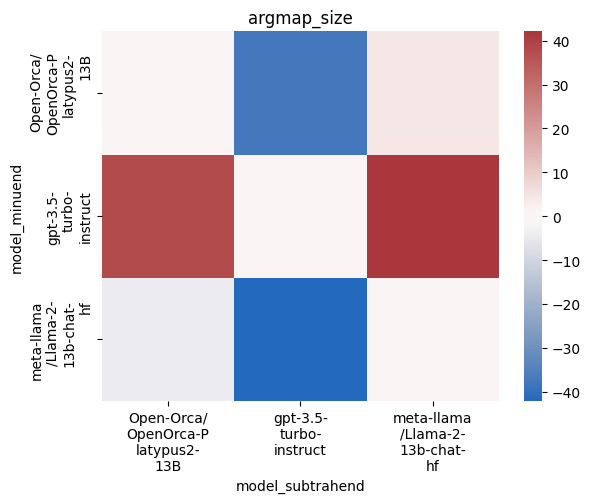

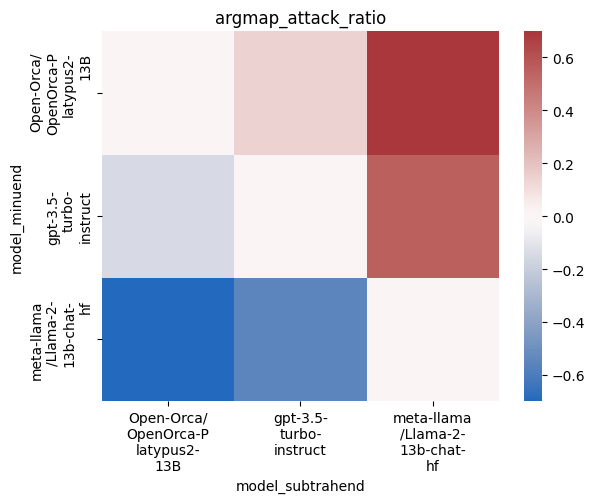

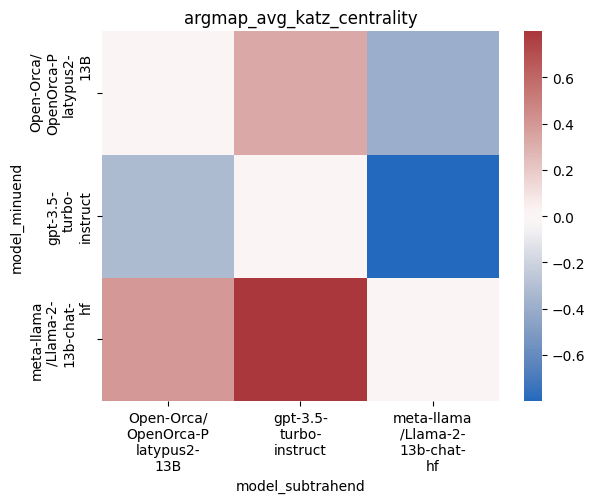

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt

for metric_label in metric_labels:

    df_diffw = df_diff[
        df_diff.metric_label.eq(metric_label)
    ].groupby(by=["model_minuend", "model_subtrahend"])["diff"].mean().unstack()

    #sorted_models = sort_models_by_metrics(metric_label)
    #print(sorted_models)
    #df_diffw = df_diffw.reindex(sorted_models, axis=0)
    #df_diffw = df_diffw.reindex(sorted_models, axis=1)
    #display(df_diffw)

    fig, ax = plt.subplots()
    sns.heatmap(df_diffw, cmap="vlag", ax=ax)
    ax.set_title(metric_label)
    fig.show()

In [8]:
import numpy as np
int(np.ceil(7 / 3))

3